# Q2SLS Function Testing

This notebook is an attempt to explore some of the properties of the Q2SLS approach that is implemented in `quadratic2SLS.py`. The setting is one in which the true DGP is quadratic in the endogenous variable. We construct the following monte carlo simulation:

### True Data Generating Process:
$$
\begin{align*}
\begin{pmatrix}
  \mathrm{X}_{1, i}\\
  \mathrm{X}_{2, i}\\
  \mathrm{X}_{3, i}\\
  \mathrm{X}_{4, i}\\
  \mathrm{Z}_{1, i}\\
  \mathrm{Z}_{2, i}
\end{pmatrix} \ &\sim \ N
\begin{bmatrix}
\begin{pmatrix}
  3\\
  -1.5\\
  1.1\\
  2.3\\
  -1\\
  3
\end{pmatrix} \ , \
\begin{pmatrix}
    1 & 0 & 0 & 0.75 & 0.8 & 0.6 \\
    0 & 1 & 0 & 0 & 0 & 0 \\
    0 & 0 & 1 & 0 & 0 & 0 \\
    0.75 & 0 & 0 & 1 & 0 & 0 \\
    0.8 & 0 & 0 & 0 & 1 & 0 \\
    0.6 & 0 & 0 & 0 & 0 & 1 \\
\end{pmatrix}
\end{bmatrix} \\
\\
\varepsilon_i \ &\sim  \ N(0, 1) \\
\\
\mathrm{Y}_i &= 1.5 + 2.5 \cdot \mathrm{X}_{1, i} - 0.7 \cdot \mathrm{X}_{1, i}^2 + 2 \cdot \mathrm{X}_{2, i} + 3 \cdot \mathrm{X}_{3, i} + 2 \cdot \mathrm{X}_{4, i} + \varepsilon_i
\end{align*}
$$

### Estimation Procedure:
Assume that we observe n observations of $[\mathrm{X}_1, \ \mathrm{X}_2, \ \mathrm{X}_3, \ \mathrm{Z}_1, \ \mathrm{Z}_2]$. In this case it is clear that $\mathrm{X}_1$ will be endogenous in an estimation of the DGP ($\mathrm{Cov}[\mathrm{X}_{1, i}, \ \mathrm{X}_{4, i}] \ne 0 \Rightarrow \mathrm{Cov}[\mathrm{X}_{1, i}, \ \mathrm{\varepsilon}_{i}]$). Standard 2SLS will not work in this setting becasue our right hand side endogenous variable is nonlinear. Here we use the "Q2SLS" procedure that Wooldridge suggests (Econometric Analysis of Cross Section and Panel Data, p.236-237) which uses what we call "nested generated regressors". The procedure is as follows:
* *First Stage*:
    - *Part A*: Regress the endogenous variable ($\mathrm{X}_1$) on the exogenous variables ($[1, \ \mathrm{X}_2, \ \mathrm{X}_3]$) and instruments ($[\mathrm{Z}_1, \ \mathrm{Z}_2]$). Retain the fitted values ($\hat{\mathrm{X}}_1$).
    - *Part B*: Regress the endogenous variable squared ($\mathrm{X}_1^2$) on the exogenous variables ($[1, \ \mathrm{X}_2, \ \mathrm{X}_3]$), instruments ($[\mathrm{Z}_1, \ \mathrm{Z}_2]$), and the fitted values from Part A squared ($\hat{\mathrm{X}}_1^2$). Retain the fitted values ($\hat{\mathrm{X}_1^2}$).
* *Second Stage*: Regress Y on the exogenous variables ($[1, \ \mathrm{X}_2, \ \mathrm{X}_3]$), instruments ($[\mathrm{Z}_1, \ \mathrm{Z}_2]$), and first stage fitted values ($[\hat{\mathrm{X}}_1, \ \hat{\mathrm{X}_1^2}]$).

### Simulation Analysis:
We run two simulations, a Strong Instruments setting (with the covariance matrix above), and a Weak Instruments setting (where the covariance between $\mathrm{X}_1$ and the instruments is 0.25 and 0.2). In each simulation we bootstrap with 100 iterations, in each iteration drawing a new sample of size n = 500,000 from the true DGP.  

We then return a table comparing the average coefficient estimates across the bootstrap iterations to the true coefficient values.  

We also plot the distributions of each coefficient across the bootstrap iterations and the convergence path of the coefficient on $\hat{\mathrm{X}}_1$ (a running average).

In [1]:
# Suppressing warnings
import warnings
warnings.filterwarnings(action = "ignore")

import quadratic2SLS as q2sls
import numpy as np
import pandas as pd
import statsmodels.api as sm
from tqdm import tqdm

# Plotting preferences
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

In [2]:
## ~~~~~ Functions ~~~~~ ##

## Coefficient Results Table ##
def results_df3(big_bootstrap_res, true_coeffs):
    '''Returns summary of coefficient results compared to true coeff.s'''
    
    coeff_estms = pd.DataFrame([true_coeffs, list(big_bootstrap_res.mean(axis=0))]).transpose()
    coeff_estms.columns = ['True_Coeffs', 'Full_Sample_Bootstrap']
    coeff_estms = coeff_estms.set_index([['const', 'endog_hat', 'endog_sq_hat', 'X2', 'X3']])
    return coeff_estms

## Coefficient Estimate Distributions ##
def custom_dist_plots3(big_bootstrap_res, results_table_out, add_to_title = ''):
    coeff_estms = results_table_out
    
    plt.figure(figsize=(16, 16))
    sns.set(style="whitegrid", palette="muted", color_codes=True)

    plt.subplots_adjust(top=0.92)
    plt.suptitle('Bootstrapped Coefficient Estimates' + str(add_to_title) + 
                 '\nBlue: Bootstrapped Coefficient Estimate\nBlack: True Coefficient')

    sns.despine()
    for column_index, column in enumerate(coeff_estms.index.tolist()):
        plt.subplot(3, 2, column_index + 1)
        sns.kdeplot(big_bootstrap_res[:,column_index])
        #plt.plot([results_obj.result2.params[column_index], results_obj.result2.params[column_index]], 
        #         [0, 500], 
        #         linewidth=1,
        #        color = 'red')
        plt.plot([coeff_estms['Full_Sample_Bootstrap'][column_index], coeff_estms['Full_Sample_Bootstrap'][column_index]], 
                 [0, 500], 
                 linewidth=1,
                color = 'blue')
        plt.plot([coeff_estms['True_Coeffs'][column_index], coeff_estms['True_Coeffs'][column_index]], 
                 [0, 500], 
                 linewidth=1,
                color = 'black')
        plt.title('Coefficient on:   `' + str(column) + '`')


## Coefficient Paths ##
def coeff_path_plot2(big_bootstrap_res, var_name, var_index, n_boot):
    cumsum_beta_hat_boots = np.cumsum(big_bootstrap_res[:, var_index])
    plt.title('Running Average from Bootstrap: `' + str(var_name) +'`')
    plt.xlabel('Bootstrap Iteration')
    plt.ylabel('Average of Bootstrapped Coefficients')
    sns.tsplot(cumsum_beta_hat_boots/np.arange(n_boot));

# Strong Instruments

In [63]:
#np.random.seed(49067)
np.random.seed(60683) # testing different seed

n = 500000
n_big_bootstrap = 100

## DGP ##
means = [3, -1.5, 1.1, 2.3, -1, 3]
cov = [[1, 0, 0, 0.75, 0.8, 0.6],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0.75, 0, 0, 1, 0, 0],
       [0.8, 0, 0, 0, 1, 0],
       [0.6, 0, 0, 0, 0, 1]]

### Bootstrapping ###
full_sample_btsp_coeff  = np.zeros((n_big_bootstrap, 5))

for BB_iter in tqdm(range(0, n_big_bootstrap)):
    ## Data Generation ##
    X1, X2, X3, X4, Z1, Z2 = np.random.multivariate_normal(means, cov, n).T

    # Normal, mean zero errors
    epsilon = np.random.normal(0, 1, n)

    # True model:
    Y = 1.5 + 2.5*X1 - 0.7*(X1)**2 + 2*X2 + 3*X3 + 2*X4 + epsilon

    ## Constructing the data sets ##
    # Note: we leave out X4 as the omitted variable from which endogeneity is arising
    exogenous = pd.DataFrame({'X2' : X2, 'X3' : X3})
    exogenous = sm.add_constant(exogenous)
    endogenous = pd.DataFrame({'X1' : X1})
    instruments = pd.DataFrame({'Z1' : Z1, 'Z2' : Z2})
    Y = pd.DataFrame({'Y' : Y})

    ## Estimating the models ##
    model1 = q2sls.Quadratic2SLS(Y, exogenous, endogenous, instruments)
    result1 = model1.fit()

    ## Results ##
    full_sample_btsp_coeff[BB_iter] = result1.result2.params

100%|██████████| 100/100 [01:09<00:00,  1.43it/s]


In [64]:
results_table = results_df3(full_sample_btsp_coeff, true_coeffs = [1.5, 2.5, -0.7, 2, 3])
results_table

,True_Coeffs,Full_Sample_Bootstrap
const,1.5,5.204740
endog_hat,2.5,2.796373
endog_sq_hat,-0.7,-0.699453
X2,2.0,1.999937
X3,3.0,2.999880


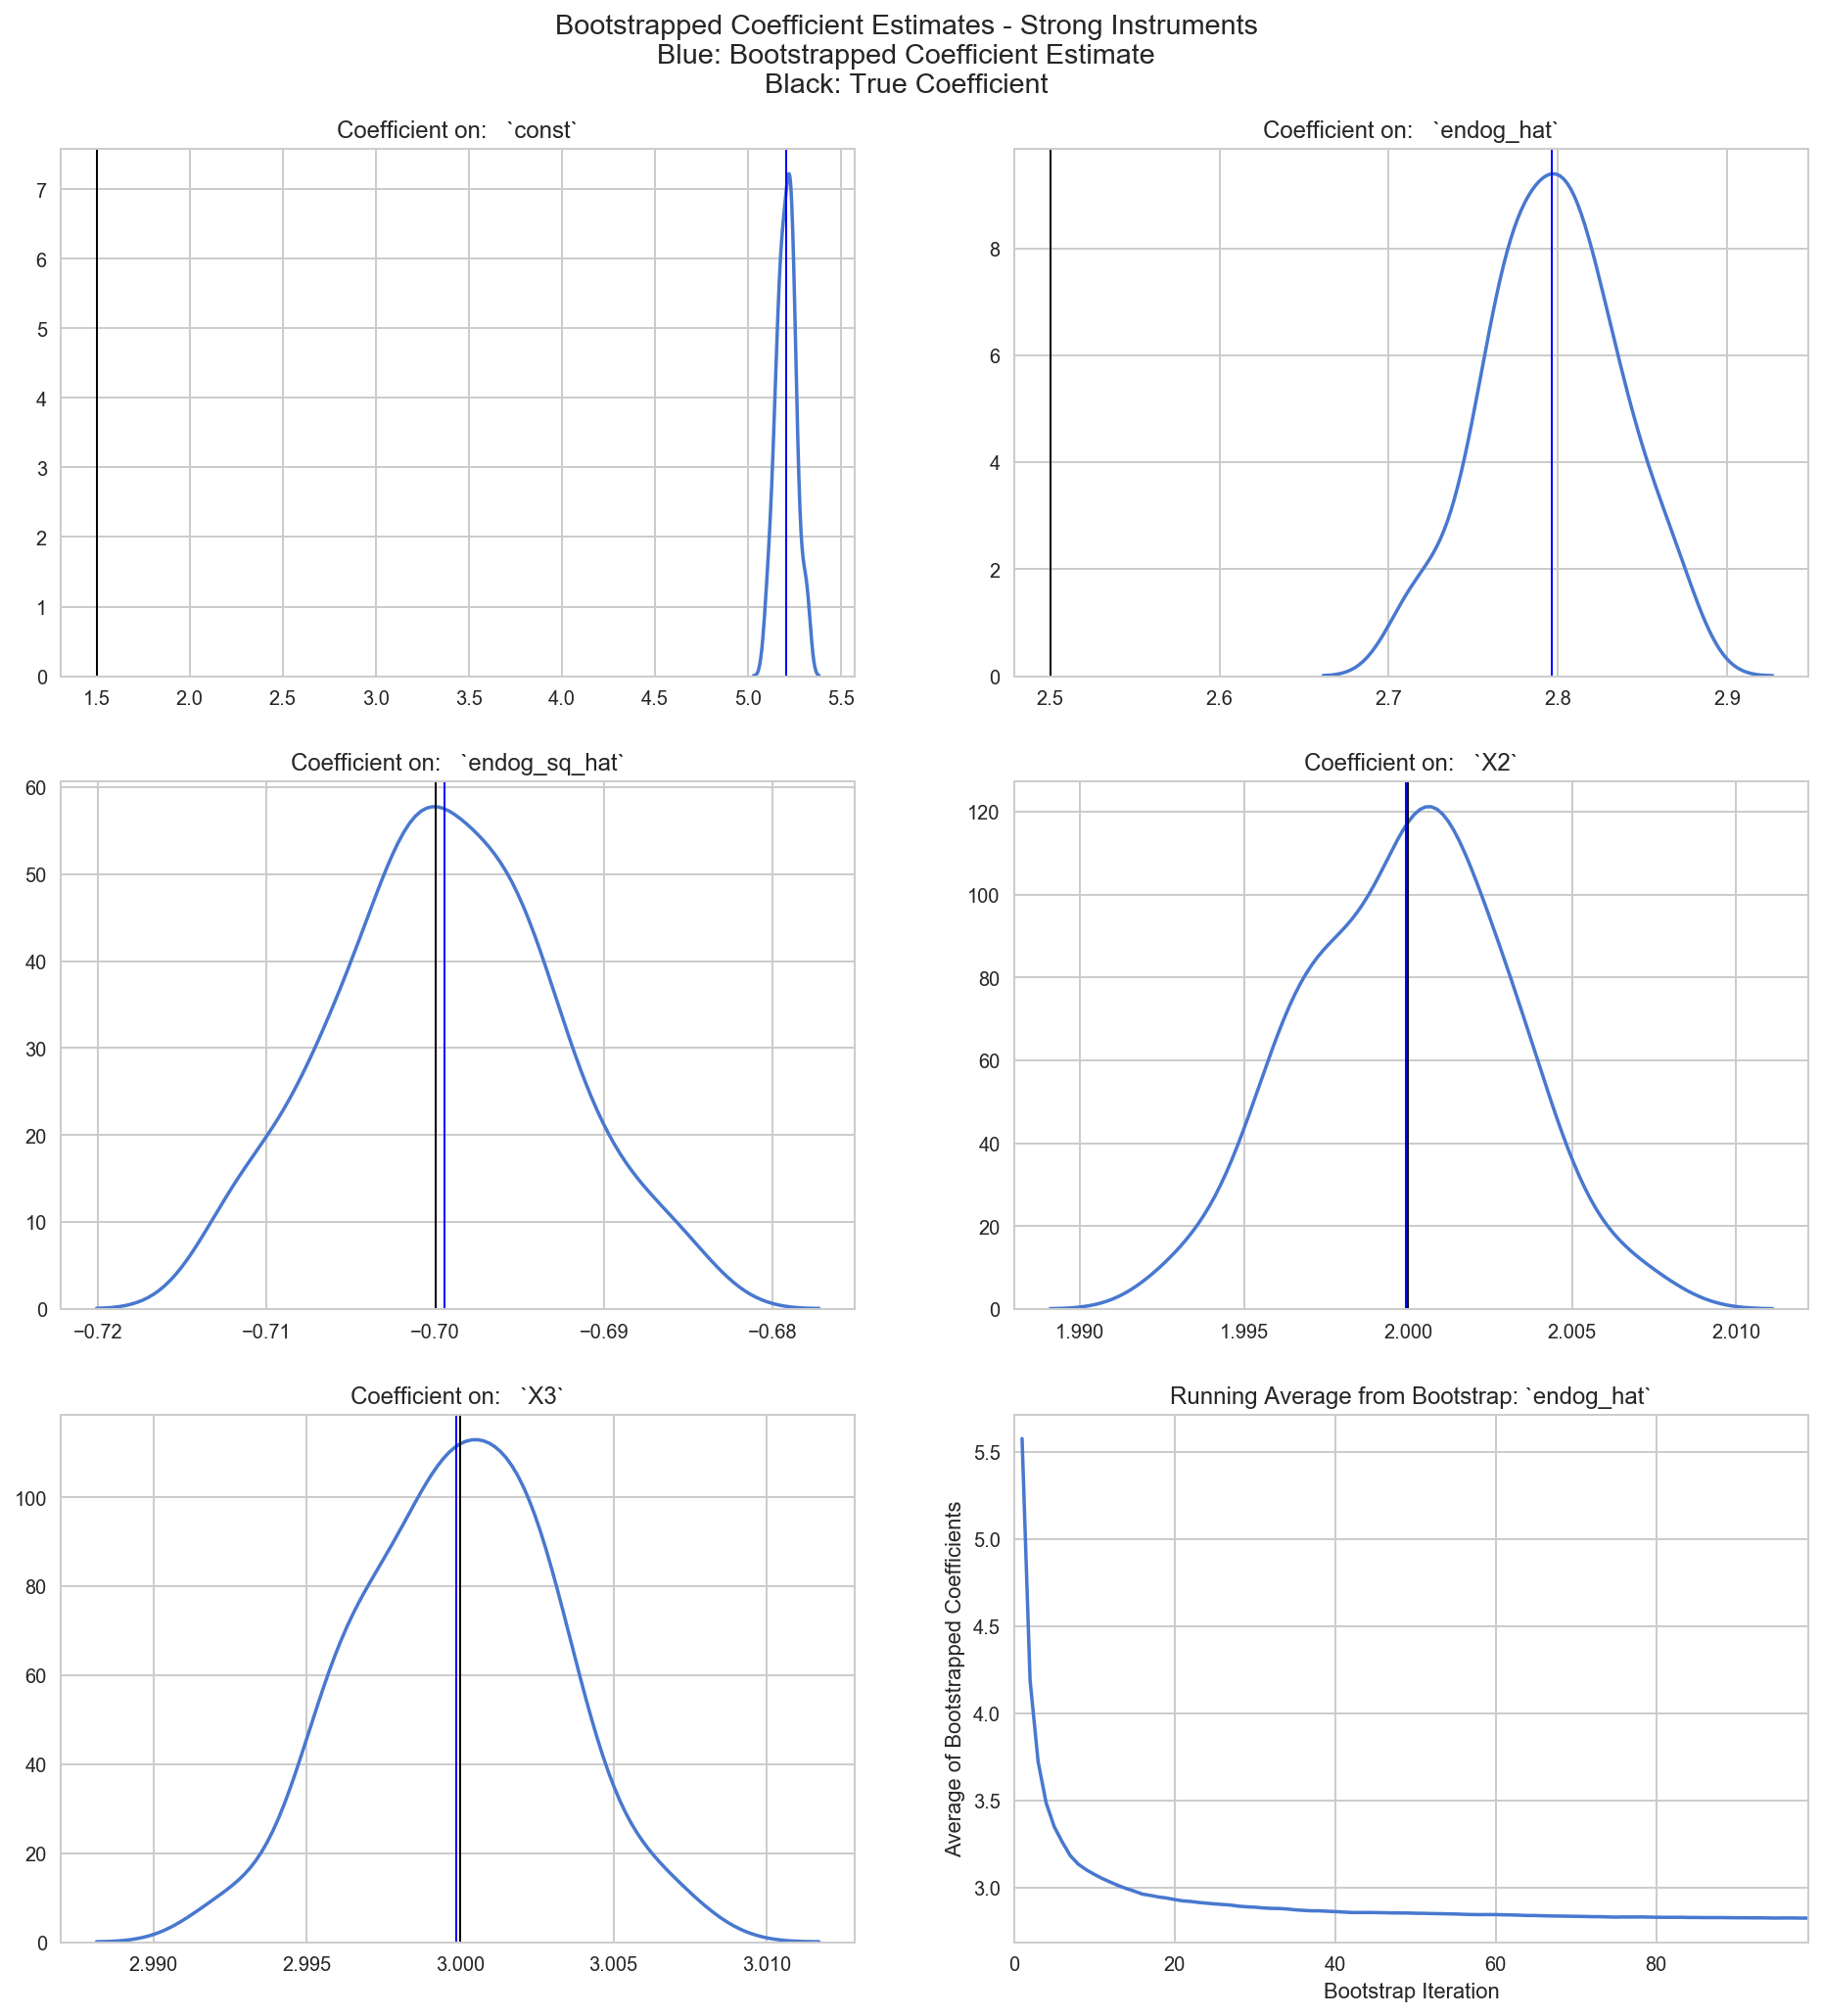

In [65]:
# Full Sample Bootstrap Distributions
custom_dist_plots3(full_sample_btsp_coeff, results_table, add_to_title=' - Strong Instruments')
# Coefficient Path
plt.subplot(3, 2, 6)
coeff_path_plot2(full_sample_btsp_coeff, 'endog_hat', 1, n_big_bootstrap)

### Strong Instruments - Results

These results are a bit confusing. Even after playing around with different random seeds, there is some weird stuff going on for all the seeds. It looks like the coefficient estimates are consistent, and that the estimates for the exogenous vars and for $\mathrm{X}_1^2$ are unbiased, but that the coefficient estimate on $\mathrm{X}_1$ is biased. This behavior is puzzling because the fitted values from the (seemingly) biased Part A are used in the Part B fitting.  

We can also try to visualize the bias as the number of observations increases, this might give us some more intuition on what is going on. In the following analysis we will limit to 50 bootstrap iterations for each sample size (looking at the convergence path for the coefficient on `endog_hat` it seems like 50 should be enough), we will save the coefficients of each of these iterations for each sample size for plotting later.

In [3]:
np.random.seed(49067)

n_levels = [1000, 3000, 5000, 10000, 25000, 50000, 100000, 250000, 500000, 625000, 750000]
n_big_bootstrap = 50

## DGP ##
means = [3, -1.5, 1.1, 2.3, -1, 3]
cov = [[1, 0, 0, 0.75, 0.8, 0.6],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0.75, 0, 0, 1, 0, 0],
       [0.8, 0, 0, 0, 1, 0],
       [0.6, 0, 0, 0, 0, 1]]

### Bootstrapping ###
btsp_coeff  = np.zeros((n_big_bootstrap * len(n_levels), 5))
samp_size = np.zeros(n_big_bootstrap * len(n_levels))

for n_idx, n in enumerate(tqdm(n_levels)):
    for BB_iter in range(0, n_big_bootstrap):
        ## Data Generation ##
        X1, X2, X3, X4, Z1, Z2 = np.random.multivariate_normal(means, cov, n).T

        # Normal, mean zero errors
        epsilon = np.random.normal(0, 1, n)

        # True model:
        Y = 1.5 + 2.5*X1 - 0.7*(X1)**2 + 2*X2 + 3*X3 + 2*X4 + epsilon

        ## Constructing the data sets ##
        # Note: we leave out X4 as the omitted variable from which endogeneity is arising
        exogenous = pd.DataFrame({'X2' : X2, 'X3' : X3})
        exogenous = sm.add_constant(exogenous)
        endogenous = pd.DataFrame({'X1' : X1})
        instruments = pd.DataFrame({'Z1' : Z1, 'Z2' : Z2})
        Y = pd.DataFrame({'Y' : Y})

        ## Estimating the models ##
        model1 = q2sls.Quadratic2SLS(Y, exogenous, endogenous, instruments)
        result1 = model1.fit()

        ## Results ##
        btsp_coeff[n_idx*n_big_bootstrap + BB_iter] = result1.result2.params
        samp_size[n_idx*n_big_bootstrap + BB_iter] = n

100%|██████████| 11/11 [02:51<00:00, 15.62s/it]


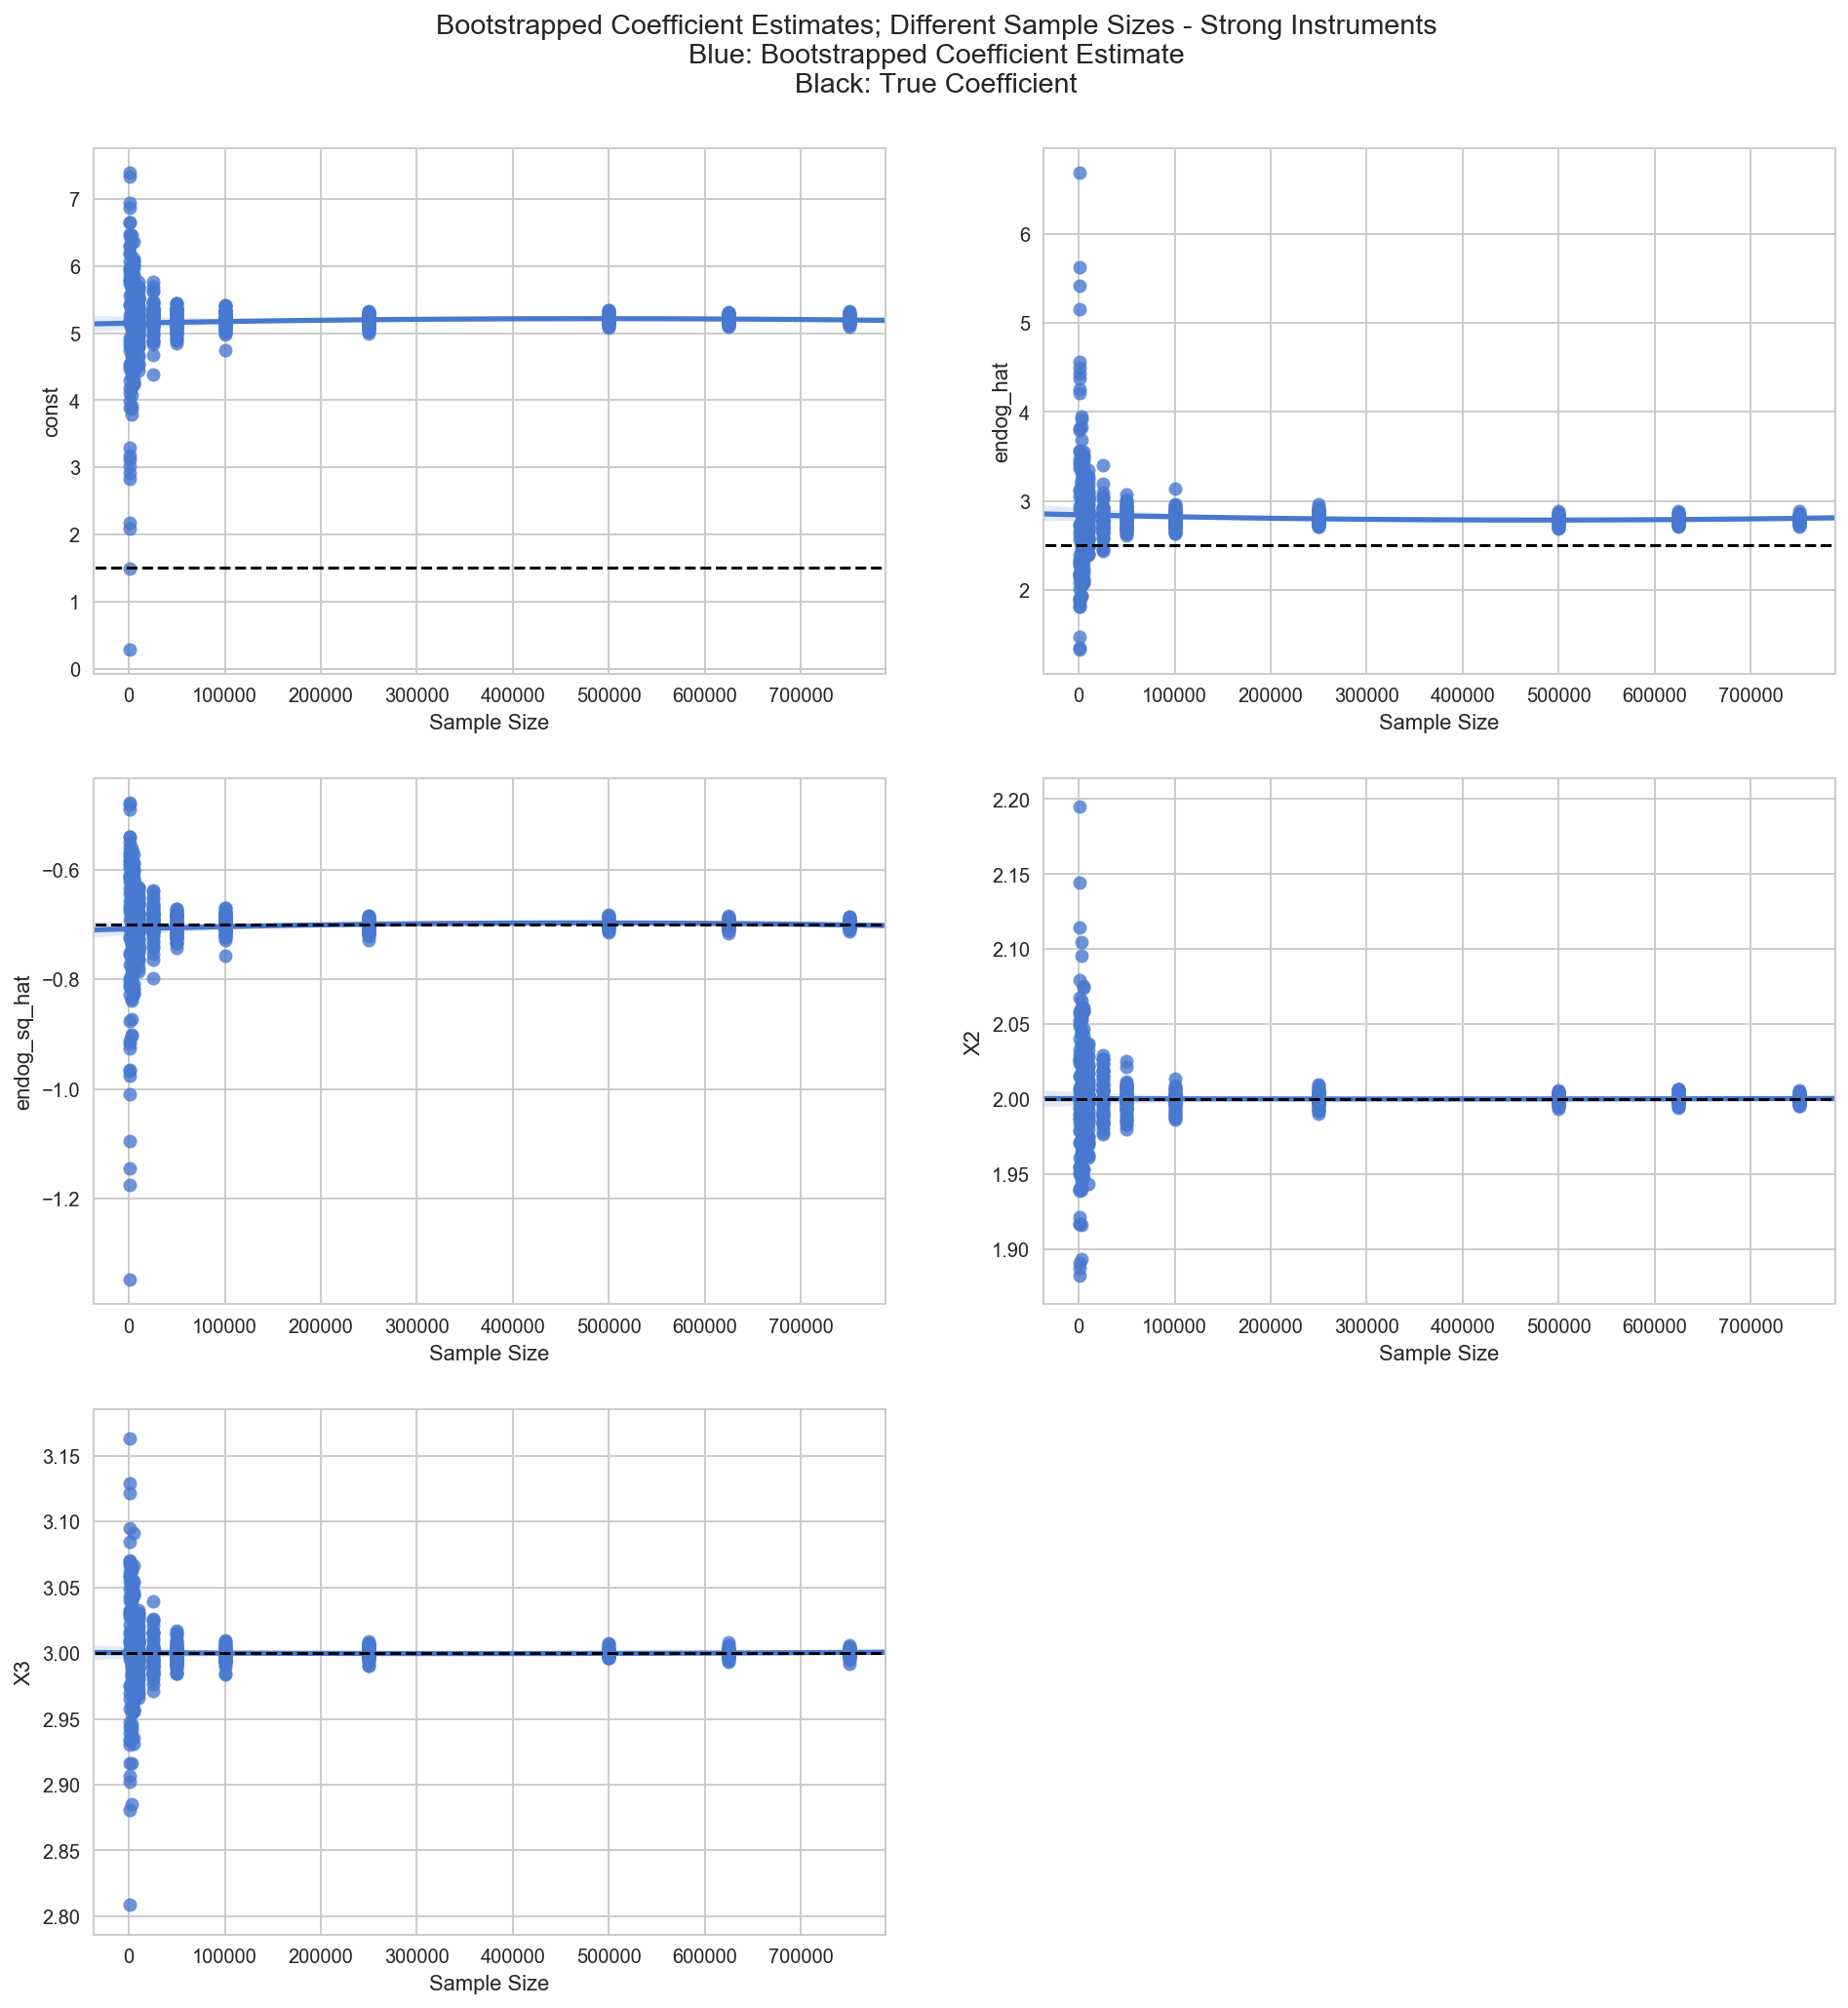

In [5]:
# Formatting results
coeffs_samp_size = pd.DataFrame(btsp_coeff, columns = ['const', 'endog_hat', 'endog_sq_hat', 'X2', 'X3'])
coeffs_samp_size.insert(0, 'n_obs', samp_size.astype(int))
true_coeffs = [1.5, 2.5, -0.7, 2, 3]

# Plotting
plt.figure(figsize=(16, 16))
sns.set(style="whitegrid", palette="muted", color_codes=True)

plt.subplots_adjust(top=0.92)
plt.suptitle('Bootstrapped Coefficient Estimates; Different Sample Sizes - Strong Instruments' #+ str(add_to_title) + 
             '\nBlue: Bootstrapped Coefficient Estimate\nBlack: True Coefficient')

sns.despine()
for column_index, column in enumerate(coeffs_samp_size.columns.tolist()[1:]):
    plt.subplot(3, 2, column_index + 1)
    sns.regplot(x='n_obs', y=column, data=coeffs_samp_size, order = 2)
    plt.plot([-100000, 1000000], 
             [true_coeffs[column_index], true_coeffs[column_index]], 
             linewidth=1.5,
             linestyle = '--', 
             color = 'black')
    plt.xlabel('Sample Size')

We find the same funky behavior in this simulation. This is not surprising (this is an extension of the original approach but with multiple sample sizes and no averaging), but it does support the same unusual conclusion we came to originally. This is something that needs to be considered more closely, as it is not immediately clear where the bias is coming from on the (1'st stage Part A estimated) endogenous variable's coefficient, and why this bias isn't affecting the coefficient on the (1'st stage Part B estimated) square of the endogenous variable.

# Weak Instruments

The only change to the DGP here is the covariance between the endogenous variable and the instruments:
$$
\begin{align*}
\begin{pmatrix}
  \mathrm{X}_{1, i}\\
  \mathrm{X}_{2, i}\\
  \mathrm{X}_{3, i}\\
  \mathrm{X}_{4, i}\\
  \mathrm{Z}_{1, i}\\
  \mathrm{Z}_{2, i}
\end{pmatrix} \ &\sim \ N
\begin{bmatrix}
\begin{pmatrix}
  3\\
  -1.5\\
  1.1\\
  2.3\\
  -1\\
  3
\end{pmatrix} \ , \
\begin{pmatrix}
    1 & 0 & 0 & 0.75 & 0.25 & 0.2 \\
    0 & 1 & 0 & 0 & 0 & 0 \\
    0 & 0 & 1 & 0 & 0 & 0 \\
    0.75 & 0 & 0 & 1 & 0 & 0 \\
    0.25 & 0 & 0 & 0 & 1 & 0 \\
    0.2 & 0 & 0 & 0 & 0 & 1 \\
\end{pmatrix}
\end{bmatrix} \\
\\
\varepsilon_i \ &\sim  \ N(0, 1) \\
\\
\mathrm{Y}_i &= 1.5 + 2.5 \cdot \mathrm{X}_{1, i} - 0.7 \cdot \mathrm{X}_{1, i}^2 + 2 \cdot \mathrm{X}_{2, i} + 3 \cdot \mathrm{X}_{3, i} + 2 \cdot \mathrm{X}_{4, i} + \varepsilon_i
\end{align*}
$$

In [51]:
np.random.seed(49067)

n = 500000
n_big_bootstrap = 100

## DGP ##
means = [3, -1.5, 1.1, 2.3, -1, 3]
cov = [[1, 0, 0, 0.75, 0.25, 0.2],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0.75, 0, 0, 1, 0, 0],
       [0.25, 0, 0, 0, 1, 0],
       [0.2, 0, 0, 0, 0, 1]]


### Big Bootstrap ###
full_sample_btsp_coeff2  = np.zeros((n_big_bootstrap, 5))

for BB_iter in tqdm(range(0, n_big_bootstrap)):
    ## Data Generation ##
    X1, X2, X3, X4, Z1, Z2 = np.random.multivariate_normal(means, cov, n).T

    # Normal, mean zero errors
    epsilon = np.random.normal(0, 1, n)

    # True model:
    Y = 1.5 + 2.5*X1 - 0.7*(X1)**2 + 2*X2 + 3*X3 + 2*X4 + epsilon

    ## Constructing the data sets ##
    # Note: we leave out X4 as the omitted variable from which endogeneity is arising
    exogenous = pd.DataFrame({'X2' : X2, 'X3' : X3})
    exogenous = sm.add_constant(exogenous)
    endogenous = pd.DataFrame({'X1' : X1})
    instruments = pd.DataFrame({'Z1' : Z1, 'Z2' : Z2})
    Y = pd.DataFrame({'Y' : Y})

    ## Estimating the models ##
    model2 = q2sls.Quadratic2SLS(Y, exogenous, endogenous, instruments)
    result2 = model2.fit()

    ## Results ##
    full_sample_btsp_coeff2[BB_iter] = result2.result2.params

100%|██████████| 100/100 [02:32<00:00,  1.53s/it]


In [52]:
results_table2 = results_df3(full_sample_btsp_coeff2, true_coeffs = [1.5, 2.5, -0.7, 2, 3])
results_table2

,True_Coeffs,Full_Sample_Bootstrap
const,1.5,6.022988
endog_hat,2.5,2.556635
endog_sq_hat,-0.7,-0.709311
X2,2.0,2.000097
X3,3.0,3.000150


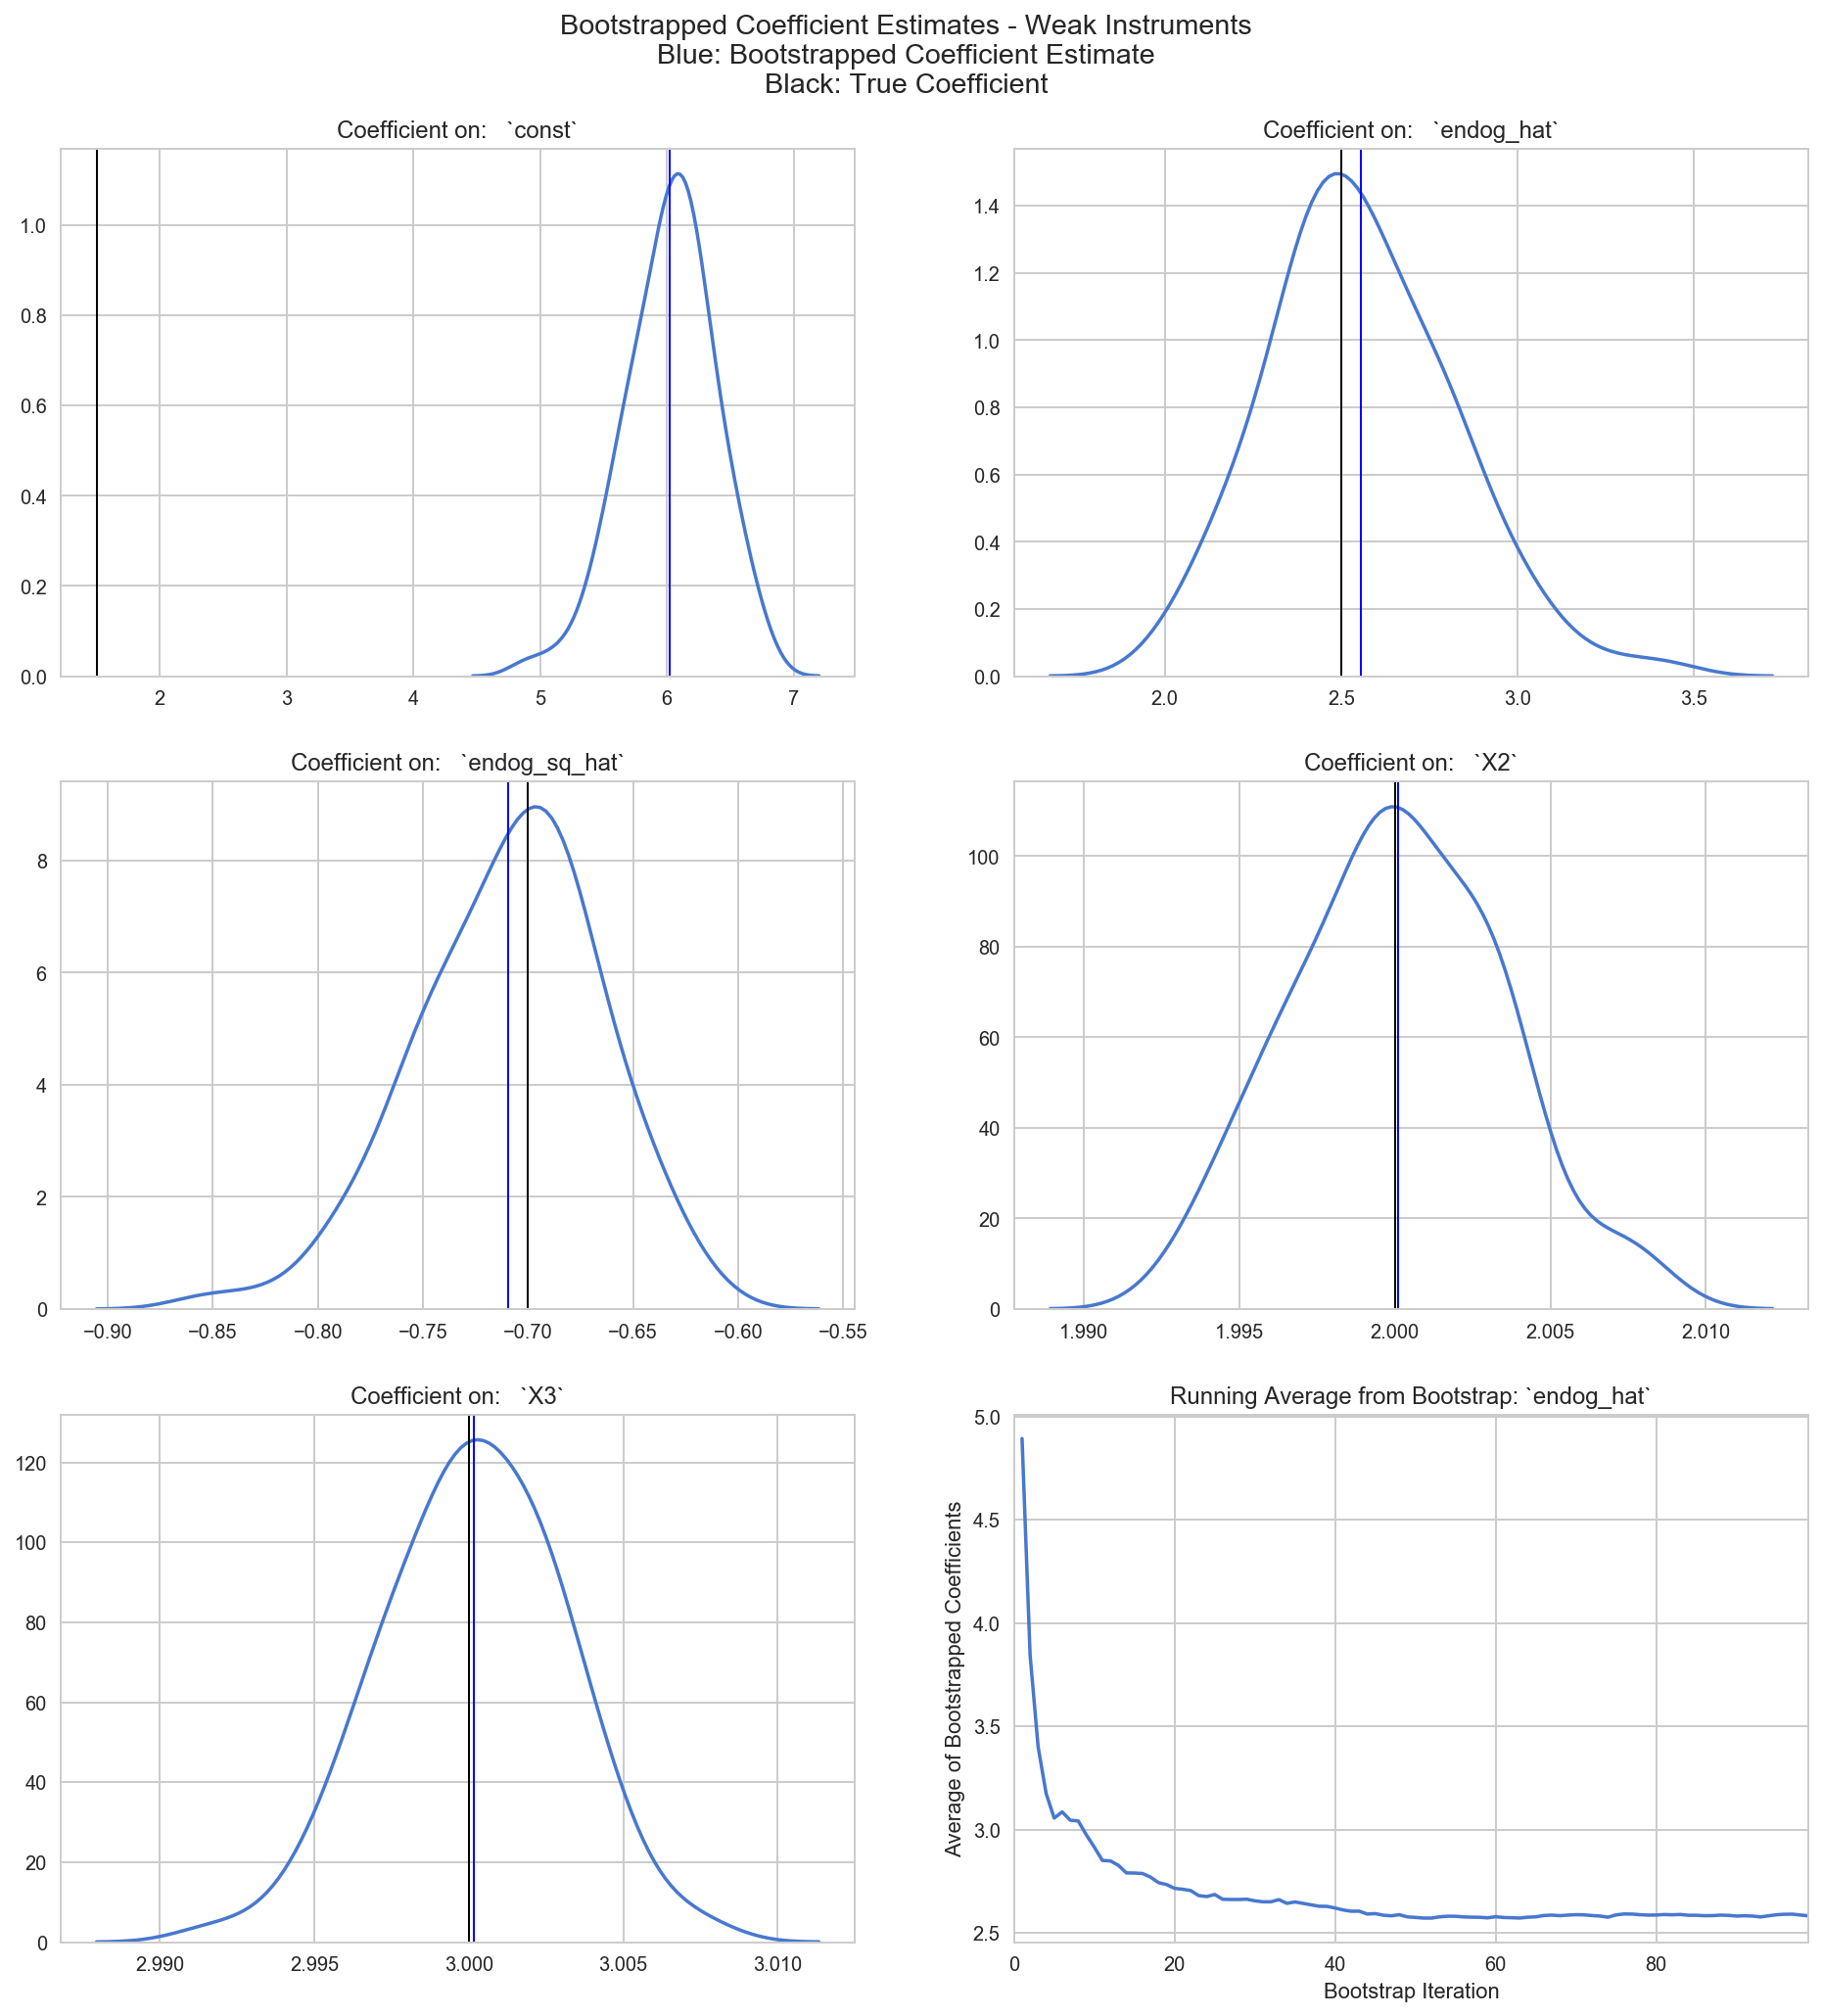

In [56]:
# Full Sample Bootstrap Distributions
custom_dist_plots3(full_sample_btsp_coeff2, results_table2, add_to_title=' - Weak Instruments')
# Coefficient Path
plt.subplot(3, 2, 6)
coeff_path_plot2(full_sample_btsp_coeff2, 'endog_hat', 1, n_big_bootstrap)